In [15]:
sys = 'dpdo280k'
trj = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/traj-dpdo280k-0-10us-pbc.xtc"
pdb = "/data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro"
start = 0
end = 1000
n_gap = 5
outpath = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + str(start) + '-' + str(end) + '_with/'
bin_width = 3
gmm_param = '/data/gulab/yzdai/data4/phase_identification/phase_out/' + sys + '/' + 'gmm_parameters.json'
# gmm_param = 'None'
fn_leaflet = '/data/gulab/yzdai/data4/phase_identification/leaflet/dpdo280k-leaflet.xvg'
primary_lipid_id = list(range(1, 347)) + list(range(577, 923))
primary_lipid_id = [str(x) for x in primary_lipid_id]
# cal_ratio = True
cal_ratio = False

In [ ]:
import matplotlib
from joblib import Parallel, delayed
import MDAnalysis
import seaborn as sns
import json
import os
from scipy.stats import norm
import argparse
from sklearn.cluster import KMeans
from matplotlib.ticker import LinearLocator
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from copy import deepcopy
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from multiprocessing import Pool
from tqdm import tqdm

In [11]:
def plot_density_distr(data, title = 'Distribution of Density'):
	# 确保数据是 NumPy 数组
	if isinstance(data, list):
		data = np.array(data)  
	# 如果是二维数组，提取第一个维度
	if data.ndim == 2:
		data = data[:, 0]
	# 检查数据是否为空
	if len(data) == 0:
		print("Error: The input data is empty.")
		return
	# 方法1：使用 seaborn 的 distplot (基础分布图)
	plt.figure(figsize=(4, 3))
	print('start of plotting')
	sns.kdeplot(data, fill=False)
	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Density')
	plt.ylabel('Probability density')
	# plt.savefig(outpath+sys+'-'+str(start)+'-density.png', dpi=350)
	# plt.close()  # 关闭图形，避免占用内存
def plot_3density_distr(data1, data2, data3, lable0='ALL',title='Distribution of Density Values'):
	plt.figure(figsize=(4, 3))
	# 计算直方图数据，增加bins的数量使基础数据更细致
	bins = np.linspace(min(np.min(data1), np.min(data2), np.min(data3)), 
					  max(np.max(data1), np.max(data2), np.max(data3)), 
					  50)  # 增加bins数量
	hist1_raw, _ = np.histogram(data1, bins=bins)
	hist2, _ = np.histogram(data2, bins=bins)
	hist3, _ = np.histogram(data3, bins=bins)

	# 转换为频率
	hist1 = hist1_raw / np.sum(hist1_raw)  # 归一化处理
	hist2 = hist2 / np.sum(hist1_raw)
	hist3 = hist3 / np.sum(hist1_raw)

	# 使用高斯滤波平滑直方图数据
	hist1_smooth = gaussian_filter(hist1, sigma=2)  # sigma控制平滑程度
	hist2_smooth = gaussian_filter(hist2, sigma=2)
	hist3_smooth = gaussian_filter(hist3, sigma=2)
	# 计算bin中心点
	bin_centers = (bins[:-1] + bins[1:]) / 2
	# 绘制平滑后的曲线
	plt.plot(bin_centers, hist1_smooth, color='black', label=lable0, linewidth=2)
	plt.plot(bin_centers, hist2_smooth, color='red', label=r"L$_{\mathit{d}}$", linewidth=2)
	plt.plot(bin_centers, hist3_smooth, color='blue', label=r"L$_{\mathit{o}}$", linewidth=2)

	plt.title(title)
	plt.tick_params(direction='in')
	plt.xlabel('Normed density')
	plt.ylabel('probability')
	plt.legend(fontsize=7, frameon=True)
	# plt.savefig(outpath+sys+'-'+str(start)+'-phase-density.png', dpi=350)
def remove_isolated_points_and_smooth(labels, iter):
	rows, cols = labels.shape
	for _ in range(iter):
		new_labels = np.copy(labels)
		for i in range(rows):
			for j in range(cols):
				# 获取周围 5x5 的邻居，考虑周期性边界条件
				neighbors = []
				for di in range(-2, 3):  # 行偏移范围 [-2, 2]
					for dj in range(-2, 3):  # 列偏移范围 [-2, 2]
						if di == 0 and dj == 0:  # 排除中心元素本身
							continue
						neighbor_value = labels[(i + di) % rows, (j + dj) % cols]
						neighbors.append(neighbor_value)
				# 统计出现次数的字典，忽略 NaN
				counts = {}
				for value in neighbors:
					if not np.isnan(value):  # 忽略 NaN
						counts[value] = counts.get(value, 0) + 1
				# 找到出现最多次的值
				max_count = -1
				most_frequent = None
				for key, count in counts.items():
					if count > max_count:
						max_count = count
						most_frequent = key
				# 替换 NaN
				new_labels[i, j] = most_frequent
		labels = np.copy(new_labels)
	return new_labels
def plot_phase(edge_list, cluster_matrix):
	 # Make figure with regular contour plot 
	levels = LinearLocator(numticks=16).tick_values(0, 1)      #这里需要改
	cmap = plt.get_cmap('RdYlBu')
	xMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	yMatrix = np.zeros((cluster_matrix.shape[0], cluster_matrix.shape[1]))
	xaxis = edge_list[0][1:]
	yaxis = edge_list[1][1:]
	for i in range(0, cluster_matrix.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, cluster_matrix.shape[1]):
		yMatrix[:, j] = yaxis

	im = plt.contourf(yMatrix,
			 xMatrix, cluster_matrix, levels=levels,
			 cmap=cmap)
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	return im
def get_lip_grid_ndx(atoms_grid_indexs, atoms_lipid, leaflet):
	# atoms_grid_indexs: natoms*5*2
	# atoms_lipid: natoms*1
	####第一步：获得每个原子在5ns中最多次定位在哪个grid,作为该原子的唯一grid index
	atoms_most_grid_index = []
	# 遍历每个原子
	for atom_grid_indexs in atoms_grid_indexs:
		# 统计当前原子的grid indexs元组出现的次数
		counter = Counter(atom_grid_indexs)
		# 得到出现次数最多的grid index元组
		most_grid_index = counter.most_common(1)[0][0]
		# 将结果加入列表
		atoms_most_grid_index.append(most_grid_index)
	# 此时atoms_most_grid_index: natoms*2....[(0,1),(0,1),...,(4,5)]
	####第二步：对于每个lipid，根据其原子，确定lipid所属的grid indexs列表
	# 创建一个字典，存放每个resid的grid indexs列表及计数
	# 类似：
	# {
	#     lipid_id_1: Counter({grid_index_1: count_1, grid_index_2: count_2, ...}),
	#     lipid_id_2: Counter({grid_index_3: count_3, grid_index_4: count_4, ...}),
	#     ...
	# }
	lip_grid_indexs = {}
	for grid_index, lipid_id in zip(atoms_most_grid_index, atoms_lipid):
		# 如果分子 ID 不在字典中，则将其添加到字典，并初始化为一个空的 Counter
		if lipid_id not in lip_grid_indexs:
			lip_grid_indexs[lipid_id] = Counter()
		# 将当前原子的标签添加到对应分子的 Counter 中
		lip_grid_indexs[lipid_id][grid_index] += 1
	for key in lip_grid_indexs.keys():
		lip_grid_counter = lip_grid_indexs[key]
		lip_grid_indexs[key] = [lip_grid_counter, leaflet]
	return lip_grid_indexs 
def get_atom_grid_position(atom_coords, x_grid_points, y_grid_points):
	x_grid_points[0] = 0
	y_grid_points[0] = 0
	grids_index = []
	for atom in atom_coords[:,:2]:
		x_coord, y_coord = atom
		# 查找在x轴和y轴上的索引
		x_index = np.searchsorted(x_grid_points, x_coord, side='left') - 1
		y_index = np.searchsorted(y_grid_points, y_coord, side='left') - 1
		grids_index.append([(x_index, y_index)]) 
		# grids_index.append([(y_index, x_index)])
	return grids_index
def simulate_PBC(points_leaflet, box, r=0.3, edge=None):
	PBC_points = []
	# 使用 edge 来限制输出范围
	if edge is not None:
		x_min, x_max = edge[0][0], edge[0][-1]
		y_min, y_max = edge[1][0], edge[1][-1]
	else:
		x_min = 0
		x_max = (1 + r) * box[0]
		y_min = 0
		y_max = (1 + r) * box[1]
	for x, y, z in points_leaflet:
		# 原始点
		if x_min < x < x_max and y_min < y < y_max:
			PBC_points.append([x, y, z])
		# 方向平移（仅 x/y）
		shifts = []
		if x > (1 - r) * box[0]: shifts.append([-box[0], 0])
		if x < r * box[0]:        shifts.append([ box[0], 0])
		if y > (1 - r) * box[1]: shifts.append([0, -box[1]])
		if y < r * box[1]:        shifts.append([0,  box[1]])
		# 斜角方向组合（左上、右上、左下、右下）
		if x > (1 - r) * box[0] and y < r * box[1]:
			shifts.append([-box[0], box[1]])
		if x > (1 - r) * box[0] and y > (1 - r) * box[1]:
			shifts.append([-box[0], -box[1]])
		if x < r * box[0] and y < r * box[1]:
			shifts.append([ box[0], box[1]])
		if x < r * box[0] and y > (1 - r) * box[1]:
			shifts.append([ box[0], -box[1]])
		# 平移后坐标加入
		for dx, dy in shifts:
			new_x, new_y = x + dx, y + dy
			if x_min < new_x < x_max and y_min < new_y < y_max:
				PBC_points.append([new_x, new_y, z])
	return np.array(PBC_points)
def cal_density(u, sel, sel_key, diffnp, edge, box_fr):
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	# h, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)

	assert np.all(h >= 0), "Histogram contains negative counts!"
	# Convert histogram to densities 
	# x_edges, y_edges, z_edges = edge
	# dx = np.diff(x_edges) 
	# dy = np.diff(y_edges) 
	# dz = np.diff(z_edges) 
	# dx_mesh, dy_mesh, dz_mesh = np.meshgrid(dx, dy, dz, indexing='ij')
	# volumes = dx_mesh * dy_mesh * dz_mesh 
	# dens3d = h / volumes

	volume = bin_width*bin_width*bin_width/6
	dens3d = h / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	mean_vals = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		nonzero = row[row > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])
	# # 策略： top 1/2 mean
	# dens2d_mean = np.zeros(shape = (dens3d.shape[0], dens3d.shape[1]))

	# for i in range(0, dens3d.shape[0]):
	#     for j in range(0, dens3d.shape[1]):
	#         all_z = dens3d[i, j, :]
	#         nonzero = all_z[all_z>0]
	#         if len(nonzero) > 0:
	#             sorted_z = sorted(nonzero, reverse=True)
	#             top_n = max(1, len(sorted_z) // 2)
	#             top_z = sorted_z[:top_n]
	#             dens2d_mean[i,j] = np.array(top_z).mean()
	# sum
	dens2d_sum = dens3d.sum(axis=2)

	# Get the grid index and resid for each atom.
	if(sel_key == 'atom_upper'):
		sel_atoms2grids_index_up = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_up =  sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_up, sel_atoms2lips_up
	elif(sel_key == 'atom_lower'):
		sel_atoms2grids_index_low = get_atom_grid_position(sel_atoms_pbc, edge[0][:], edge[1][:])
		sel_atoms2lips_low = sel_atoms_obj.resids
		return dens2d_sum, dens2d_mean, sel_atoms2grids_index_low, sel_atoms2lips_low
	else:
		return dens2d_sum, dens2d_mean
def get_lipis_tags(tags_up_all, tags_low_all, lips_grid_ndx):
	lips_tag = []
	for t in range(len(lips_grid_ndx)): #200
		lips_tag_fr = []
		for lip_index in range(len(lips_grid_ndx[0])):  #对于每个lip的n个grid index
			lip_grids_counter, leaflet = lips_grid_ndx[t][lip_index]
			lip_tag_counts = Counter()
			for grid_index, count in lip_grids_counter.items():
				(i, j) = grid_index
				if (leaflet == 0): #gird index 转为tag
					tag = int(tags_up_all[t][i][j])
				else:
					tag = int(tags_low_all[t][i][j])
				lip_tag_counts[tag] += count
			most_common_tag, _ = lip_tag_counts.most_common(1)[0]
			lips_tag_fr.append(most_common_tag)
		lips_tag.append(lips_tag_fr)
	return lips_tag
def spatial_smooth(matrix, n_iter=2, n_size =3):
	new_matrix = deepcopy(matrix)
	for i in range(n_iter):
		new_matrix = np.around(uniform_filter(new_matrix, size = n_size, mode='wrap'), decimals=6)
	return new_matrix
def replace_zeros_with_neighbors_mean(matrix):
	# 确定矩阵的大小
	n = matrix.shape[0]
	
	# 创建一个新的矩阵来存储结果，以避免在原矩阵中修改时影响计算
	result_matrix = matrix.copy()
	
	# 遍历每个元素
	for i in range(n):
		for j in range(n):
			if matrix[i, j] == 0:
				# 获取周围元素的值
				neighbors = []
				if i > 0:
					neighbors.append(matrix[i-1, j])
				if i < n-1:
					neighbors.append(matrix[i+1, j])
				if j > 0:
					neighbors.append(matrix[i, j-1])
				if j < n-1:
					neighbors.append(matrix[i, j+1])
				
				# 计算周围元素的均值
				if neighbors:
					mean_value = np.mean(neighbors)
					result_matrix[i, j] = mean_value
	
	return result_matrix
def get_tag_by_first_feature(data,raw_tags):
	# 计算每个聚类中第一个特征的均值
	means = []
	for cluster in set(raw_tags):
		cluster_points = data[raw_tags == cluster]  # 提取当前标签对应的样本
		mean_value = cluster_points[:, 0].mean()  # 计算第一个特征的均值
		means.append((cluster, mean_value))
	# 根据均值大小重新定义标签
	means.sort(key=lambda x: x[1])  # 按均值排序，较小均值排在前面
	mapping = {means[0][0]: 0, means[1][0]: 1}  # 均值小的映射为 2，均值大的映射为 1
	# 映射原始标签到新的标签
	new_tags = np.array([mapping[tag] for tag in raw_tags])
	return new_tags
def combine_tags(tags_2, new_tags_of1):
	# 创建一个与原始标签相同长度的数组
	final_tags = np.copy(tags_2)
	# 找到原始标签中为1的索引
	indices_of_1 = np.where(tags_2 == 1)[0]
	# 将二次分类的结果放回原来的位置
	# 如果二次分类为1的部分要标记为2，可以将new_tags_of1加1
	final_tags[indices_of_1] = new_tags_of1
	return final_tags
def cluster_all(atom_dens_mean_up_all_raw, atom_dens_mean_low_all_raw,
				k=2, iterations=1, gmm_param=None):
	if gmm_param != 'None':
		# Step 1: 读取 JSON 文件
		with open(gmm_param, 'r') as json_file:
			params = json.load(json_file)
		# 提取 Ld 和 Lo 的参数
		density_mean = params['density']['mean']
	else:
		density_mean = np.mean(atom_dens_mean_up_all_raw)/2+np.mean(atom_dens_mean_low_all_raw)/2
	# 数据处理，空间上均值滤波
	density_up_filtered_all = []
	density_low_filtered_all = []
	for n_fr in range(atom_dens_mean_up_all_raw.shape[0]):
		density_mean_up_fr = atom_dens_mean_up_all_raw[n_fr]
		density_mean_low_fr = atom_dens_mean_low_all_raw[n_fr]
		if np.any(density_mean_up_fr == 0):
			density_mean_up_fr = replace_zeros_with_neighbors_mean(density_mean_up_fr)
		if np.any(density_mean_low_fr == 0):
			density_mean_low_fr = replace_zeros_with_neighbors_mean(density_mean_low_fr)
		# 对原始数值进行空间上均值滤波
		density_up_normed_fr = density_mean_up_fr/density_mean
		density_low_normed_fr = density_mean_low_fr/density_mean
		density_up_filtered_fr = spatial_smooth(density_up_normed_fr)
		density_low_filtered_fr = spatial_smooth(density_low_normed_fr)

		density_up_filtered_all.append(density_up_filtered_fr)
		density_low_filtered_all.append(density_low_filtered_fr)
	density_up_filtered_all = np.array(density_up_filtered_all)
	density_low_filtered_all = np.array(density_low_filtered_all)
	# 将数组转换为2D形式，以便进行KMeans聚类
	n_leaflet_samples = atom_dens_mean_up_all_raw.shape[0]*atom_dens_mean_up_all_raw.shape[1]*atom_dens_mean_up_all_raw.shape[2]
	density_up_flattened = density_up_filtered_all.reshape(n_leaflet_samples, -1).tolist()
	density_low_flattened = density_low_filtered_all.reshape(n_leaflet_samples, -1).tolist()
	density_flattened = density_up_flattened + density_low_flattened
	# [atom]
	flattened_matrix = density_flattened
	# 去除NA
	flattened_matrix = np.where(np.isnan(flattened_matrix), 0, flattened_matrix)
	# 检查 NaN
	has_nan = np.isnan(flattened_matrix).any()
	if has_nan:
		print("Array contains NaN values.")
	# 检查 Infinity
	has_inf = np.isinf(flattened_matrix).any()
	if has_inf:
		print("Array contains infinite values.")
	###画分布图###
	plot_density_distr(flattened_matrix, title=sys+' '+str(start)+'-'+str(end))
	# 开始分类
	if (gmm_param != 'None'):
		n_fr  = density_up_filtered_all.shape[0]
		tags_up_all = []; tags_low_all = []
		for fr in range(n_fr):
			filter_fr = threshold_max - (threshold_max - threshold_min) * fr/n_fr
			density_up_filtered_fr = density_up_filtered_all[fr]
			tags_up_fr = (density_up_filtered_fr > filter_fr).astype(int)
			tags_up_all.append(tags_up_fr)
			density_low_filtered_fr = density_low_filtered_all[fr]
			tags_low_fr = (density_low_filtered_fr > filter_fr).astype(int)
			tags_low_all.append(tags_low_fr)
		tags_up_flattened = np.array(tags_up_all).reshape(n_leaflet_samples, -1).tolist()
		tags_low_flattened = np.array(tags_low_all).reshape(n_leaflet_samples, -1).tolist()
		tags = tags_up_flattened + tags_low_flattened
		tags = np.array(tags)

	if (gmm_param == 'None'):
		# Step 1: 高斯混合模型拟合
		gmm = GaussianMixture(n_components=k, random_state=0).fit(flattened_matrix)   
		raw_tags = gmm.predict(flattened_matrix)

		# Step 2: 对 raw_tags 进行处理，得到最终标签 tags
		tags = get_tag_by_first_feature(flattened_matrix,raw_tags)

		# Step 3: 根据 tags 提取 Lo 和 Ld 的分布参数
		ld_indices = (tags == 0)  # Ld 标签为 0
		lo_indices = (tags == 1)  # Lo 标签为 1
		# 提取 Ld 和 Lo 样本
		ld_samples = flattened_matrix[ld_indices]
		lo_samples = flattened_matrix[lo_indices]
		# 计算 Ld 和 Lo 的均值和标准差
		mu_ld, sigma_ld = ld_samples.mean(), ld_samples.std()
		mu_lo, sigma_lo = lo_samples.mean(), lo_samples.std()
		min_lo = min(flattened_matrix[tags == 1])
		max_ld = max(flattened_matrix[tags == 0])
		# Step 4: 保存到 JSON 文件
		output_data = {
			"Ld": {
				"tag": 0,
				"mean": float(mu_ld),
				"std": float(sigma_ld),
				"max density": float(max_ld)
			},
			"Lo": {
				"tag": 1,
				"mean": float(mu_lo),
				"std": float(sigma_lo),
				"min density": float(min_lo)
			},
			"density": {
				"mean": float(density_mean)
			}
		}
		with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'gmm_parameters.json'), 'w') as json_file:
			json.dump(output_data, json_file, indent=4)
	# else:
		####方法1：看哪个概率密度大
		# Step 1: 读取 JSON 文件
		# with open(gmm_param, 'r') as json_file:
		#     params = json.load(json_file)
		# # 提取 Ld 和 Lo 的参数
		# mu_ld = params['Ld']['mean']
		# sigma_ld = params['Ld']['std']
		# mu_lo = params['Lo']['mean']
		# sigma_lo = params['Lo']['std']
		# mu_ubld = params['unbalanced_Ld']['mean']
		# sigma_ubld = params['unbalanced_Ld']['std']
		# # Step 2: 计算每个样本的概率密度
		# prob_ld_1 = norm.pdf(flattened_matrix, loc=mu_ld, scale=sigma_ld)  # 属于 Ld 的概率密度
		# prob_ld_2 = norm.pdf(flattened_matrix, loc=mu_ubld, scale=sigma_ubld)  # 属于 Ld 的概率密度
		# prob_ld = np.maximum(prob_ld_1, prob_ld_2)
		# prob_lo = norm.pdf(flattened_matrix, loc=mu_lo, scale=sigma_lo)  # 属于 Lo 的概率密度
		# # Step 3: 分类规则
		# tags = np.where(prob_lo > prob_ld, 1, 
		#         np.where(prob_lo < prob_ld, 0, np.nan))
		
		# ####方法2：单侧检验
		# mu_lo = params['Lo']['mean']
		# sigma_lo = params['Lo']['std']
		# z_score = norm.ppf(0.80)  # 单侧 90% 显著性水平对应的 Z 值（可根据需求调整）
		# # 计算特征值较大的阈值
		# threshold = mu_lo - z_score * sigma_lo  # 比较大的样本特征值阈值
		# print(f"分类阈值 (80% 左单侧显著): {threshold:.3f}")
		# tags = np.where(flattened_matrix > threshold, 1, 0)

		# ####方法3：动态threshold
		# tags = np.where(flattened_matrix > threshold, 1, 0)
		# print('Threshold:\t',threshold)
	print('Lo min:\t',min(flattened_matrix[tags == 1]))
	print('Ld max:\t',flattened_matrix[tags == 0].max())
	plot_3density_distr(flattened_matrix,
					flattened_matrix[tags == 0], 
					flattened_matrix[tags == 1], 
					title=sys+' '+str(start)+'-'+str(end))
	# 将标签数组重新分割为tag_up和tag_low，并还原其形状
	split_idx = len(tags) // 2
	tag_matrixs_up = tags[:split_idx].reshape(atom_dens_mean_up_all_raw.shape[0],atom_dens_mean_up_all_raw.shape[1],atom_dens_mean_up_all_raw.shape[2])
	tag_matrixs_low = tags[split_idx:].reshape(atom_dens_mean_up_all_raw.shape[0],atom_dens_mean_up_all_raw.shape[1],atom_dens_mean_up_all_raw.shape[2])
	# 在像素化平面针对grid的tag进行空间平滑
	final_tag_matrixs_up = deepcopy(tag_matrixs_up)
	final_tag_matrixs_low = deepcopy(tag_matrixs_low)
	for n_fr in range(atom_dens_mean_up_all_raw.shape[0]):
		tag_matrix_up_fr = tag_matrixs_up[n_fr]
		tag_matrix_low_fr = tag_matrixs_low[n_fr]
		final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrix_up_fr, iter=iterations) #控制是否平滑
		final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrix_low_fr, iter=iterations) #控制是否平滑
	print('end of clustering all')
	return final_tag_matrixs_up, final_tag_matrixs_low
def split_into_segments(sequence):
	segments = []
	current_char = sequence[0]
	count = 1
	
	for char in sequence[1:]:
		if char == current_char:
			count += 1
		else:
			segments.append((current_char, count))
			current_char = char
			count = 1
	segments.append((current_char, count))
	return segments
def merge_segments(segments):
	tmp = list(''.join([char * count for char, count in segments]))
	return tmp
def correct_min_repeat_tags(segments, repeat = 2):
	for r in range(1, repeat+1):
		# print('r = ',r)
		iter = 0
		while True:
			iter += 1
			# print('1st: iter: ' + str(iter))
			if iter > 2000:
				raise RuntimeError("Error: Iteration limit exceeded, potential infinite loop detected!")
			corrected_segments = segments.copy()
			for i in range(len(segments)):
				char, count = segments[i]
				if(len(segments) >= 3):
					if count <= r:
						if i == 0 and len(segments) > 1:
							# 首个segment的处理
							right_char, right_count = segments[i+1]
							if right_count > repeat:
								corrected_segments[i] = (right_char, count)
						elif i == len(segments) - 1 and len(segments) > 1:
							# 末尾segment的处理
							left_char, left_count = segments[i-1]
							if left_count > repeat:
								corrected_segments[i] = (left_char, count)
						else:
							# 中间segment的处理
							left_char, left_count = segments[i-1]
							right_char, right_count = segments[i+1]
							
							if left_count > r or right_count > r:
								if left_count >= right_count:
									corrected_segments[i] = (left_char, count)
								else:
									corrected_segments[i] = (right_char, count)
				else:
					if count <= repeat:
						if (i + 1 < len(segments)):
							right_char, right_count = segments[i+1]
							corrected_segments[i] = (right_char, count)
						else:
							left_char, left_count = segments[i-1]
							corrected_segments[i] = (left_char, count)
			cor_seq = merge_segments(corrected_segments)
			# print(cor_seq)
			segments = split_into_segments(cor_seq)
			
			if r < repeat:
				if all(count > r for char, count in segments[1:-1]) \
				   and len(segments)>=3:
					break
				elif( len(segments)<3):
					break
			else:
				if all(count > r for char, count in segments):
					break
	return segments
def temporal_smoothing (matrix):
	columns = [matrix[:, i].tolist() for i in range(matrix.shape[1])]
	new_columns = []
	for sequence in columns:
		# print('raw sequence:',end = ' ')
		# print(sequence)
		sequence    = [str(x) for x in sequence]
		segments = split_into_segments(sequence)
		corrected_segs = correct_min_repeat_tags(segments)
		corrected_sequence = merge_segments(corrected_segs)
		corrected_sequence = [int(x) for x in corrected_sequence]
		new_columns.append(corrected_sequence) 
		# print('new sequence:',end = ' ')
		# print(final_corrected_sequence)
	new_array = np.array(list(map(np.array, zip(*new_columns))))
	return new_array

单独取5ns做实验

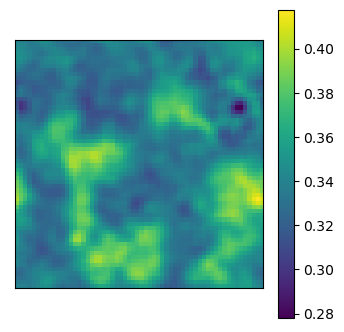

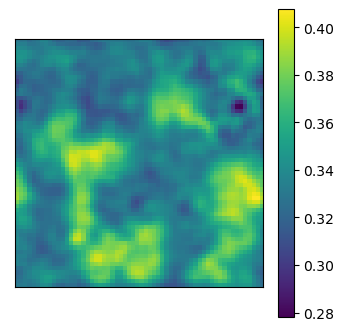

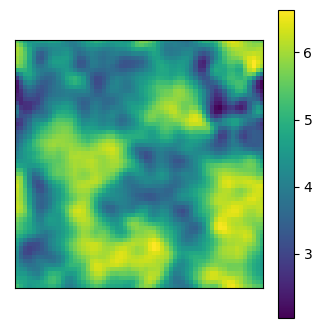

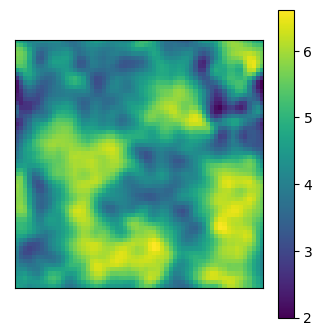

In [169]:
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-1-10us-pbc.xtc"
# fn_leaflet='/data/gulab/yzdai/dyz_project2/leaflet/dpdochl280k-leaflet.xvg'
# primary_lipid_id = list(range(1, 203)) + list(range(577, 779))
# lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
# start = 8000
# end = 9000
# b = 8945
# e = 8950
# leaflets = lip_leaflet_raw[b:e, :]
# most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*leaflets)]
# upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
# lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
# sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
# sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
# upper_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(upper_resid_list))]
# lower_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(lower_resid_list))]
# sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
# sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])
b = 9945
e = 9950
u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width*6))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width/6, z_bins + 1)
edge = (x_edges, y_edges, z_edges)
def cal_f(u, index):
	ts = u.trajectory[index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])
	sel = 'resid ' + ' '.join([str(x) for x in range(1, 577)])
	# sel = sel_atom_upper
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)
	h2, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	assert np.all(h >= 0), "Histogram contains negative counts!"

	volume = bin_width*bin_width*bin_width/6
	dens3d = h / volume
	dens3d2 = h2 / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	reshaped2 = dens3d2.reshape(xy, z)
	mean_vals = np.zeros(xy)
	mean_vals2 = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		row2 = reshaped2[i]
		nonzero = row[row > 0]
		nonzero2 = row2[row2 > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
		if len(nonzero2) > 0:
			sorted_vals = np.sort(nonzero2)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals2[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])
	dens2d_mean2 = mean_vals2.reshape(dens3d.shape[0], dens3d.shape[1])
	dens2d_sum = dens3d.sum(axis=2)
	dens2d_sum2 = dens3d2.sum(axis=2)
	return(dens2d_mean, dens2d_mean2, dens2d_sum, dens2d_sum2)

results = [
	cal_f(u, frame)
	for frame in list(range(b, e))
]
h1 = spatial_smooth(np.mean([r[0] for r in results], axis=0))
h2 = spatial_smooth(np.mean([r[1] for r in results], axis=0))
h3 = spatial_smooth(np.mean([r[2] for r in results], axis=0))
h4 = spatial_smooth(np.mean([r[3] for r in results], axis=0))
def plot_matrix(matrix, title="Matrix Plot", cmap='viridis'):
	"""
	使用指定的颜色映射绘制给定的n*m矩阵。
	
	参数:
	- matrix: 要绘制的二维numpy数组 (n, m)
	- title: 图像的标题，默认为 "Matrix Plot"
	- cmap: 使用的颜色映射，默认为 'viridis'
	"""
	rotated_matrix = np.flipud(np.transpose(matrix))
	plt.figure(figsize=(4, 4))
	# 使用imshow绘制矩阵，并应用颜色映射
	plt.imshow(rotated_matrix, cmap=cmap, origin='lower')
	plt.gca().invert_yaxis()  # 反转Y轴
	plt.colorbar()  # 添加颜色条以显示值的范围
	# 隐藏x轴和y轴的刻度
	plt.xticks([])
	plt.yticks([])
	plt.show()
plot_matrix(h1, title="Matrix1", cmap='viridis')
plot_matrix(h2, title="Matrix2", cmap='viridis')
plot_matrix(h3, title="Matrix2", cmap='viridis')
plot_matrix(h4, title="Matrix2", cmap='viridis')

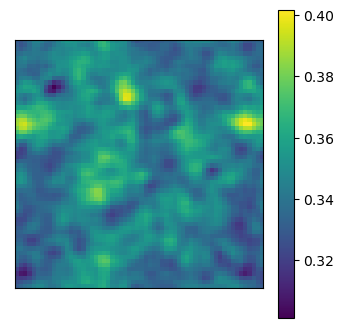

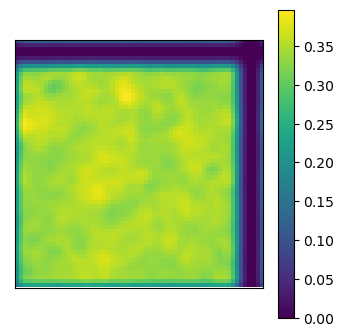

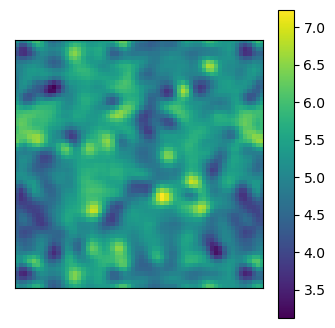

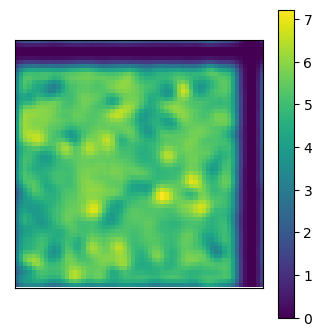

In [ ]:
# pdb="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/snapshot9.99us.gro"
# trj="/data/gulab/yzdai/dyz_project1/data/dppc_dopc_chl_280k/dpdochl280k-1-10us-pbc.xtc"
# fn_leaflet='/data/gulab/yzdai/dyz_project2/leaflet/dpdochl280k-leaflet.xvg'
# primary_lipid_id = list(range(1, 203)) + list(range(577, 779))
# lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
# start = 8000
# end = 9000
# b = 8945
# e = 8950
# leaflets = lip_leaflet_raw[b:e, :]
# most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*leaflets)]
# upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
# lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
# sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
# sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
# upper_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(upper_resid_list))]
# lower_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(lower_resid_list))]
# sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
# sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])

u = MDAnalysis.Universe(pdb, trj)
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width*6))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width/6, z_bins + 1)
edge = (x_edges, y_edges, z_edges)
def cal_f(u, index):
	ts = u.trajectory[index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])
	# sel = 'resid ' + ' '.join([str(x) for x in range(1, 577)])
	# Get the coordinates of the selected atoms
	sel_atoms_obj = u.select_atoms(sel)
	sel_atoms = sel_atoms_obj.positions
	# Move the com of system to the center of present box
	sel_atoms_com = np.add(sel_atoms, diffnp)
	# Rescale the coordinates between 0 - present boxsize
	sel_atoms_pbc = np.mod(sel_atoms_com, box_fr)
	# Generate some fake points to simulate PBC to fill the max box
	PBC_points = simulate_PBC(sel_atoms_pbc, box_fr, r=0.3, edge = edge) 
	# Get the number of atoms within each grid
	h, _ = np.histogramdd(PBC_points, bins=edge, normed = False)
	h2, _ = np.histogramdd(sel_atoms_pbc, bins=edge, normed = False)
	assert np.all(h >= 0), "Histogram contains negative counts!"

	volume = bin_width*bin_width*bin_width/6
	dens3d = h / volume
	dens3d2 = h2 / volume

	# Collapse along the z-axis
	# top 1/2 mean
	xy = dens3d.shape[0] * dens3d.shape[1]
	z = dens3d.shape[2]
	reshaped = dens3d.reshape(xy, z)
	reshaped2 = dens3d2.reshape(xy, z)
	mean_vals = np.zeros(xy)
	mean_vals2 = np.zeros(xy)
	for i in range(xy):
		row = reshaped[i]
		row2 = reshaped2[i]
		nonzero = row[row > 0]
		nonzero2 = row2[row2 > 0]
		if len(nonzero) > 0:
			sorted_vals = np.sort(nonzero)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals[i] = np.mean(sorted_vals[-num_keep:])
		if len(nonzero2) > 0:
			sorted_vals = np.sort(nonzero2)
			num_keep = max(1, len(sorted_vals) // 2)
			mean_vals2[i] = np.mean(sorted_vals[-num_keep:])
	dens2d_mean = mean_vals.reshape(dens3d.shape[0], dens3d.shape[1])
	dens2d_mean2 = mean_vals2.reshape(dens3d.shape[0], dens3d.shape[1])
	dens2d_sum = dens3d.sum(axis=2)
	dens2d_sum2 = dens3d2.sum(axis=2)
	return(dens2d_mean, dens2d_mean2, dens2d_sum, dens2d_sum2)

results = [
	cal_f(u, frame)
	for frame in list(range(b, e))
]
h1 = spatial_smooth(np.mean([r[0] for r in results], axis=0))
h2 = spatial_smooth(np.mean([r[1] for r in results], axis=0))
h3 = spatial_smooth(np.mean([r[2] for r in results], axis=0))
h4 = spatial_smooth(np.mean([r[3] for r in results], axis=0))
def plot_matrix(matrix, title="Matrix Plot", cmap='viridis'):
	"""
	使用指定的颜色映射绘制给定的n*m矩阵。
	
	参数:
	- matrix: 要绘制的二维numpy数组 (n, m)
	- title: 图像的标题，默认为 "Matrix Plot"
	- cmap: 使用的颜色映射，默认为 'viridis'
	"""
	rotated_matrix = np.flipud(np.transpose(matrix))
	plt.figure(figsize=(4, 4))
	# 使用imshow绘制矩阵，并应用颜色映射
	plt.imshow(rotated_matrix, cmap=cmap, origin='lower')
	plt.gca().invert_yaxis()  # 反转Y轴
	plt.colorbar()  # 添加颜色条以显示值的范围
	# 隐藏x轴和y轴的刻度
	plt.xticks([])
	plt.yticks([])
	plt.show()
plot_matrix(h1, title="Matrix1", cmap='viridis')
plot_matrix(h2, title="Matrix2", cmap='viridis')
plot_matrix(h3, title="Matrix2", cmap='viridis')
plot_matrix(h4, title="Matrix2", cmap='viridis')

In [140]:
print(PBC_points.shape)
print(sel_atoms_pbc.shape)
print(sel_atoms.shape)

(78166, 3)
(76582, 3)
(76582, 3)


# Para

小并行

In [ ]:
from multiprocessing import Pool
def process_frame(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower, sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio):
	"""
	独立加载 Universe 并处理每一帧数据
	"""
	# 每个子进程独立加载 Universe
	u = MDAnalysis.Universe(pdb, trj)
	# 跳转到指定帧
	ts = u.trajectory[frame_index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])

	# 计算原子密度
	atom_up_sum, atom_up_mean, atoms2grid_up_fr, atoms2lip_up = cal_density(sel_atom_upper, 'atom_upper', diffnp, edge, box_fr)
	atom_low_sum, atom_low_mean, atoms2grid_low_fr, atoms2lip_low = cal_density(sel_atom_lower, 'atom_lower', diffnp, edge, box_fr)

	# 计算 primary lipid 密度（根据 cal_ratio）
	primary_lipid_up_sum, primary_lipid_up_mean = None, None
	primary_lipid_low_sum, primary_lipid_low_mean = None, None
	if cal_ratio:
		primary_lipid_up_sum, primary_lipid_up_mean = cal_density(sel_primary_lipid_upper, 'primary_lipid_upper', diffnp, edge, box_fr)
		primary_lipid_low_sum, primary_lipid_low_mean = cal_density(sel_primary_lipid_lower, 'primary_lipid_lower', diffnp, edge, box_fr)

	# 返回每一帧的结果
	return atom_up_sum, atom_up_mean, atom_low_sum, atom_low_mean, primary_lipid_up_sum, primary_lipid_low_sum,\
	atoms2grid_up_fr, atoms2lip_up, atoms2grid_low_fr, atoms2lip_low

u = MDAnalysis.Universe(pdb, trj)
# 初始化变量
box_x = 0; box_y = 0; box_z = 0
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width, z_bins + 1)
edge = (x_edges, y_edges, z_edges)

lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]
print_t = 0
lips_grid_ndx = []
# Initialize
h_atom_up_mean_all = []  # (end-start)//n_gap * x * y
h_atom_low_mean_all = []
if cal_ratio:
	h_atom_up_sum_all = []  # (end-start)//n_gap * x * y
	h_atom_low_sum_all = []
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []

lips_grid_ndx = []  # 200*1152*2
for b in range(start, end, n_gap):
	print(str(print_t), end=' ')
	print_t += 1
	e = b + n_gap
	leaflets = lip_leaflet_raw[b:e, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*leaflets)]
	upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
	lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
	sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
	sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
	upper_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(upper_resid_list))]
	lower_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(lower_resid_list))]
	sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
	sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])

	frame_indices = list(range(b, e))

	# 使用 multiprocessing.Pool 并行处理
	with Pool(processes=5) as pool:
		results = pool.starmap(
			process_frame,
			[(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower,
				sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio)
				for frame_index in frame_indices]
		)

	# 处理结果
	h_atom_up_mean = np.mean([r[1] for r in results], axis=0)
	h_atom_low_mean = np.mean([r[3] for r in results], axis=0)
	if(cal_ratio):
		h_atom_up_sum = np.mean([r[0] for r in results], axis=0)
		h_atom_low_sum = np.mean([r[2] for r in results], axis=0)
		h_primary_lipid_up_sum = np.mean([r[4] for r in results], axis=0)
		h_primary_lipid_low_sum = np.mean([r[5] for r in results], axis=0)
	atoms2lip_up = results[0][7]
	atoms2lip_low = results[0][9]

	atoms2grid_up = None
	atoms2grid_low = None
	for i, (atoms2grid_up_fr, atoms2grid_low_fr) in enumerate(zip([r[6] for r in results], [r[8] for r in results])):
		if i == 0:
			atoms2grid_up = deepcopy(atoms2grid_up_fr)
			atoms2grid_low = deepcopy(atoms2grid_low_fr)
		else:
			atoms2grid_up = [a + b for a, b in zip(atoms2grid_up, atoms2grid_up_fr)]
			atoms2grid_low = [a + b for a, b in zip(atoms2grid_low, atoms2grid_low_fr)]

	lip2grid_up = get_lip_grid_ndx(atoms2grid_up, atoms2lip_up, 0)
	lip2grid_low = get_lip_grid_ndx(atoms2grid_low, atoms2lip_low, 1)
	all_lips2grid_ndx = {**lip2grid_up, **lip2grid_low}
	sorted_keys = sorted(all_lips2grid_ndx.keys())
	sorted_grid_ndx = [all_lips2grid_ndx[key] for key in sorted_keys]
	lips_grid_ndx.append(sorted_grid_ndx)
	# Append results
	h_atom_up_mean_all.append(h_atom_up_mean)
	h_atom_low_mean_all.append(h_atom_low_mean)

	if cal_ratio:
		h_atom_up_sum_all.append(h_atom_up_sum)
		h_atom_low_sum_all.append(h_atom_low_sum)
		h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
		h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)
print('end of density calculation')

大并行

In [12]:


def process_frame(pdb, trj, frame_index, sel_atom_upper, sel_atom_lower, sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio):
	"""
	独立加载 Universe 并处理每一帧数据
	"""
	# 跳转到指定帧
	u = MDAnalysis.Universe(pdb, trj)
	ts = u.trajectory[frame_index]
	box_fr = ts.dimensions[:3]
	sel_all_com = u.select_atoms('all').center_of_mass()
	diffx = box_fr[0] / 2 - sel_all_com[0]
	diffy = box_fr[1] / 2 - sel_all_com[1]
	diffz = box_fr[2] / 2 - sel_all_com[2]
	diffnp = np.array([diffx, diffy, diffz])

	# 计算原子密度
	atom_up_sum, atom_up_mean, atoms2grid_up_fr, atoms2lip_up = cal_density(u, 
		sel_atom_upper, 'atom_upper', diffnp, edge, box_fr)
	atom_low_sum, atom_low_mean, atoms2grid_low_fr, atoms2lip_low = cal_density(u, 
		sel_atom_lower, 'atom_lower', diffnp, edge, box_fr)

	# 计算 primary lipid 密度（根据 cal_ratio）
	primary_lipid_up_sum, primary_lipid_up_mean = None, None
	primary_lipid_low_sum, primary_lipid_low_mean = None, None
	if cal_ratio:
		primary_lipid_up_sum, primary_lipid_up_mean = cal_density(u, 
			sel_primary_lipid_upper, 'primary_lipid_upper', diffnp, edge, box_fr)
		primary_lipid_low_sum, primary_lipid_low_mean = cal_density(u, 
			sel_primary_lipid_lower, 'primary_lipid_lower', diffnp, edge, box_fr)

	# 返回每一帧的结果
	return atom_up_sum, atom_up_mean, atom_low_sum, atom_low_mean, \
		   primary_lipid_up_sum, primary_lipid_low_sum, \
		   atoms2grid_up_fr, atoms2lip_up, atoms2grid_low_fr, atoms2lip_low

def process_block(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge, cal_ratio):
	"""
	处理一个 n_gap 范围块的任务，并返回所有需要的结果
	"""
	lips_grid_ndx_block = []
	h_atom_up_mean_all = []
	h_atom_low_mean_all = []
	h_atom_up_sum_all = []
	h_atom_low_sum_all = []
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []
# 创建一个进度条对象，范围是从 start_block 到 end_block
	block_progress = tqdm(range(start_block, end_block, n_gap), desc="Processing Blocks", leave=True, position=0)
	for b in block_progress:
		e = min(b + n_gap, end_block)  # 确保不超出范围
		fr5_leaflets = lip_leaflet_raw[b:e, :]
		most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fr5_leaflets)]
		upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
		lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
		sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
		sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
		upper_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in upper_resid_list])))]
		lower_primary_lipid_list = [str(x) for x in sorted(list(set([int(idx) for idx in primary_lipid_id]) & set([int(idx) for idx in lower_resid_list])))]
		sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
		# print(sel_primary_lipid_upper)
		sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])
		# if(b == 9500):
		#     print(sel_atom_upper)
		#     print(sel_primary_lipid_upper)
		# 创建一个帧级别的进度条对象
		frame_indices = list(range(b, e))
		frame_progress = tqdm(frame_indices, desc=f"Frames {b}-{e}", leave=False, position=1)
		# 串行处理每一帧
		results = [
			process_frame(pdb, trj, frame, sel_atom_upper, sel_atom_lower,
						  sel_primary_lipid_upper, sel_primary_lipid_lower, edge, cal_ratio)
			for frame in frame_progress
		]

		atoms2lip_up = results[0][7]
		atoms2lip_low = results[0][9]

		for i, (atoms2grid_up_fr, atoms2grid_low_fr) in enumerate(zip([r[6] for r in results], [r[8] for r in results])):
			if i == 0:
				atoms2grid_up = deepcopy(atoms2grid_up_fr)
				atoms2grid_low = deepcopy(atoms2grid_low_fr)
			else:
				atoms2grid_up = [raw + new for raw, new in zip(atoms2grid_up, atoms2grid_up_fr)]
				atoms2grid_low = [raw + new for raw, new in zip(atoms2grid_low, atoms2grid_low_fr)]

		lip2grid_up = get_lip_grid_ndx(atoms2grid_up, atoms2lip_up, 0)
		lip2grid_low = get_lip_grid_ndx(atoms2grid_low, atoms2lip_low, 1)
		all_lips2grid_ndx = {**lip2grid_up, **lip2grid_low}
		sorted_keys = sorted(all_lips2grid_ndx.keys())
		sorted_grid_ndx = [all_lips2grid_ndx[key] for key in sorted_keys]
		lips_grid_ndx_block.append(sorted_grid_ndx)

		# 添加到结果列表
		h_atom_up_mean = np.mean([r[1] for r in results], axis=0)
		h_atom_low_mean = np.mean([r[3] for r in results], axis=0)
		h_atom_up_mean_all.append(h_atom_up_mean)
		h_atom_low_mean_all.append(h_atom_low_mean)
		if cal_ratio:
			h_atom_up_sum = np.mean([r[0] for r in results], axis=0)
			h_atom_low_sum = np.mean([r[2] for r in results], axis=0)
			h_primary_lipid_up_sum = np.mean([r[4] for r in results], axis=0)
			h_primary_lipid_low_sum = np.mean([r[5] for r in results], axis=0)
			h_atom_up_sum_all.append(h_atom_up_sum)
			h_atom_low_sum_all.append(h_atom_low_sum)
			h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
			h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)

	# 返回块的所有结果
	return lips_grid_ndx_block, h_atom_up_mean_all, h_atom_low_mean_all, \
		   h_atom_up_sum_all, h_atom_low_sum_all, h_primary_lipid_up_sum_all, h_primary_lipid_low_sum_all

u = MDAnalysis.Universe(pdb, trj)
box_x = box_y = box_z = 0
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
x_bins = int(np.ceil(max_box[0] / bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width*6))
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width/6, z_bins + 1)
edge3d = (x_edges, y_edges, z_edges)

lip_leaflet_raw = np.loadtxt(fn_leaflet)[:, 1:]

# 将 start 到 end 分成若干块
num_blocks = 10  # 并行块的数量
block_size = (end - start) // num_blocks
blocks = [(start + i * block_size, start + (i + 1) * block_size) for i in range(num_blocks)]
blocks[-1] = (blocks[-1][0], end)  # 确保最后一块包含剩余的帧

def process_block_wrapper_with_index(args):
	start_block = args[2]
	result = process_block(*args)
	return start_block, result

# 外层并行化
with Pool(processes=num_blocks) as pool:
	all_results = list(tqdm(
		pool.imap_unordered(
			process_block_wrapper_with_index,
			[(pdb, trj, start_block, end_block, lip_leaflet_raw, primary_lipid_id, edge3d, cal_ratio)
			 for start_block, end_block in blocks]
		),
		total=len(blocks),
		desc="Processing Blocks"
	))
# 按起始索引排序
all_results.sort(key=lambda x: x[0])  # 按 start_block 排序
# 提取排序后的结果
all_results = [result for _, result in all_results]
# 合并所有块的结果
lips_grid_ndx = [item for block_result in all_results for item in block_result[0]]
h_atom_up_mean_all = [item for block_result in all_results for item in block_result[1]]
h_atom_low_mean_all = [item for block_result in all_results for item in block_result[2]]

if cal_ratio:
	h_atom_up_sum_all = [item for block_result in all_results for item in block_result[3]]
	h_atom_low_sum_all = [item for block_result in all_results for item in block_result[4]]
	h_primary_lipid_up_sum_all = [item for block_result in all_results for item in block_result[5]]
	h_primary_lipid_low_sum_all = [item for block_result in all_results for item in block_result[6]]

print('End of density calculation')

Processing Blocks: 100%|██████████| 10/10 [18:41<00:00, 112.16s/it]

End of density calculation


# Raw


In [81]:
u = MDAnalysis.Universe(pdb, trj)
box_x = 0;box_y = 0;box_z = 0
# find the biggest box
for ts in u.trajectory[start:end]:
	box = ts.dimensions[:3]
	box_x = max(box_x, box[0])
	box_y = max(box_y, box[1])
	box_z = max(box_z, box[2])
max_box = (box_x, box_y, box_z)
# Calculate the number of grids for x, y, z axes
x_bins = int(np.ceil(max_box[0]/ bin_width))
y_bins = int(np.ceil(max_box[1] / bin_width))
z_bins = int(np.ceil(max_box[2] / bin_width))
# edge generation
x_edges = np.linspace(0, 0 + x_bins * bin_width, x_bins + 1)
y_edges = np.linspace(0, 0 + y_bins * bin_width, y_bins + 1)
z_edges = np.linspace(0, 0 + z_bins * bin_width, z_bins + 1)
edge = (x_edges, y_edges, z_edges)
#Initialization
print_t=0
h_atom_up_mean_all=[] # (end-start)//n_gap * x * y
h_atom_low_mean_all=[]
if(cal_ratio):
	h_atom_up_sum_all=[] # (end-start)//n_gap * x * y
	h_atom_low_sum_all=[]
	h_primary_lipid_up_sum_all = []
	h_primary_lipid_low_sum_all = []
lips_grid_ndx=[] #200*1152*2
#main
print('pdb:',pdb,'\nstart:\t',start,'\tend:\t',end,'\n---------------------------------')
lip_leaflet_raw = np.loadtxt(fn_leaflet)[:,1:]
for b in range(start, end, n_gap):
	print(str(print_t), end=' ')
	print_t += 1
	e = b + n_gap
	leaflets = lip_leaflet_raw[b:e, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*leaflets)]
	upper_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 0]
	lower_resid_list = [str(index+1) for index, value in enumerate(most_common_leaflet_tag) if value == 1]
	sel_atom_upper = 'resid ' + ' '.join(upper_resid_list)
	sel_atom_lower = 'resid ' + ' '.join(lower_resid_list)
	upper_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(upper_resid_list))]
	lower_primary_lipid_list = [str(x) for x in list(set(primary_lipid_id) & set(lower_resid_list))]
	sel_primary_lipid_upper = 'resid ' + ' '.join([str(x) for x in upper_primary_lipid_list])
	sel_primary_lipid_lower = 'resid ' + ' '.join([str(x) for x in lower_primary_lipid_list])

	# define the initial value of densmap
	x_zeros = np.zeros((10, 2))
	h_atom_up_sum, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
	h_atom_low_sum, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
	h_atom_up_mean, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
	h_atom_low_mean, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
	if(cal_ratio):
		h_primary_lipid_up_sum, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
		h_primary_lipid_low_sum, _ = np.histogramdd(x_zeros, bins = (x_bins, y_bins), range = [[0.5, 1], [0.5, 1]])
	count = 0
	# Calculation of mean atomic density and mean primary lipid occupancy over 5 ns
	for ts in u.trajectory[b:e]:
		box_fr = ts.dimensions[:3]
		
		sel_all_com = u.select_atoms('all').center_of_mass()
		diffx = box_fr[0]/2 - sel_all_com[0]
		diffy = box_fr[1]/2 - sel_all_com[1]
		diffz = box_fr[2]/2 - sel_all_com[2]
		diffnp = np.array([diffx, diffy, diffz])

		atom_up_sum, atom_up_mean, atoms2grid_up_fr, atoms2lip_up = cal_density(sel_atom_upper, 'atom_upper', diffnp, edge, box_fr)
		atom_low_sum, atom_low_mean, atoms2grid_low_fr, atoms2lip_low = cal_density(sel_atom_lower, 'atom_lower', diffnp, edge, box_fr)
		if(cal_ratio):
			primary_lipid_up_sum, primary_lipid_up_mean = cal_density(sel_primary_lipid_upper, 'primary_lipid_upper', diffnp, edge, box_fr)
			primary_lipid_low_sum, primary_lipid_low_mean = cal_density(sel_primary_lipid_lower, 'primary_lipid_lower', diffnp, edge, box_fr)

		h_atom_up_sum = np.add(h_atom_up_sum, atom_up_sum/float(n_gap))
		h_atom_low_sum = np.add(h_atom_low_sum, atom_low_sum/float(n_gap))
		h_atom_up_mean = np.add(h_atom_up_mean, atom_up_mean/float(n_gap))
		h_atom_low_mean = np.add(h_atom_low_mean, atom_low_mean/float(n_gap))
		if(cal_ratio):
			h_primary_lipid_up_sum = np.add(h_primary_lipid_up_sum, primary_lipid_up_sum/float(n_gap))
			h_primary_lipid_low_sum = np.add(h_primary_lipid_low_sum, primary_lipid_low_sum/float(n_gap))
			
		# Put the index of the grid where the atoms are located in each frame in a list
		# [[(1, 2), (1, 2),...], [(2, 3), (2, 3),...], [(1, 3), (1, 3),...]]
		if (int(ts.frame) == b):
			atoms2grid_up = deepcopy(atoms2grid_up_fr)
			atoms2grid_low = deepcopy(atoms2grid_low_fr)
		else:
			atoms2grid_up = [atoms2grid_up[i] + atoms2grid_up_fr[i] for i in range(len(atoms2grid_up_fr))]
			atoms2grid_low = [atoms2grid_low[i] + atoms2grid_low_fr[i] for i in range(len(atoms2grid_low_fr))]
		count += 1
	lip2grid_up=get_lip_grid_ndx(atoms2grid_up, atoms2lip_up, 0)#字典
	lip2grid_low=get_lip_grid_ndx(atoms2grid_low, atoms2lip_low, 1)#字典
	all_lips2grid_ndx = {**lip2grid_up, **lip2grid_low}
	sorted_keys = sorted(all_lips2grid_ndx.keys())
	# The corresponding grid index counter and leaflet label for each lipid within 5ns
	sorted_grid_ndx = [all_lips2grid_ndx[key] for key in sorted_keys] 
	lips_grid_ndx.append(sorted_grid_ndx)

	h_atom_up_mean_all.append(h_atom_up_mean)
	h_atom_low_mean_all.append(h_atom_low_mean)
	if( cal_ratio):
		h_atom_up_sum_all.append(h_atom_up_sum)
		h_atom_low_sum_all.append(h_atom_low_sum)
		h_primary_lipid_up_sum_all.append(h_primary_lipid_up_sum)
		h_primary_lipid_low_sum_all.append(h_primary_lipid_low_sum)
print('end of density calculation')

pdb: /data/gulab/yzdai/dyz_project1/data/dppc_dopc_280k/dppc_dopc_280k_0us.gro 
start:	 9000 	end:	 10000 
---------------------------------
0 1 2 3 4 5 6 7 8 9 10 11 12 13 

KeyboardInterrupt: 

# Analysis

start: 0 	end: 1000 
density_mean: 0.3452694396184943
start of plotting
start: 0 	end: 1000 
mean: 0.9829024651086716 	std: 0.041187683933502486


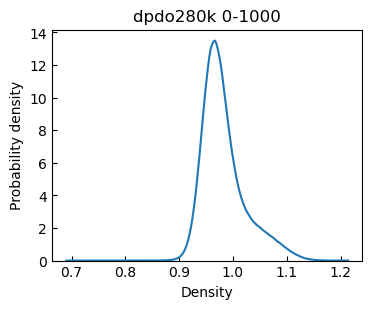

In [13]:
# 得到非平衡态的均值和方差
if gmm_param != 'None':
	with open(gmm_param, 'r') as json_file:
		params = json.load(json_file)
	density_mean = params['density']['mean']
else:
	density_mean = np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2

print('start:',start,'\tend:',end,'\ndensity_mean:',density_mean)
h_atom_up_mean_all_normed = [matrix / density_mean for matrix in h_atom_up_mean_all]
h_atom_low_mean_all_normed = [matrix / density_mean for matrix in h_atom_low_mean_all]
h_atom_up_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_up_mean_all_normed]
h_atom_low_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_low_mean_all_normed] 

if(cal_ratio):
	h_ratio_up_all = [h_primary_lipid_up_sum_all[fr]/h_atom_up_sum_all[fr] for fr in range(len(h_primary_lipid_up_sum_all))]
	h_ratio_low_all = [h_primary_lipid_low_sum_all[fr]/h_atom_low_sum_all[fr] for fr in range(len(h_primary_lipid_low_sum_all))]
	h_ratio_up_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_up_all]
	h_ratio_low_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_low_all]
	
h_up_all = np.array(h_atom_up_mean_all_normed_filtered)
h_low_all = np.array(h_atom_low_mean_all_normed_filtered)

n_leaflet_samples = h_up_all.shape[0]*h_up_all.shape[1]*h_up_all.shape[2]
density_up_flattened = h_up_all.reshape(n_leaflet_samples, -1).tolist()
density_low_flattened = h_low_all.reshape(n_leaflet_samples, -1).tolist()
density_flattened = density_up_flattened + density_low_flattened
# [atom]
flattened_matrix = np.array(deepcopy(density_flattened)).reshape(-1,1)
plot_density_distr(flattened_matrix, title=sys+' '+str(start)+'-'+str(end))

mean = np.mean(flattened_matrix)
std = np.std(flattened_matrix)
print('start:',start,'\tend:',end,'\nmean:',mean,'\tstd:',std)


## 将normed filtered density 写入文件

In [57]:
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/threshold/dpdo280k_first_1us.xvg'
# 将 density_flattened 写入文件
with open(file_path, 'w') as file:
    for value in flattened_matrix:
        print(value, file=file)

print(f"Data written to {file_path}")

Data written to /data/gulab/yzdai/data4/phase_identification/plot/input/threshold/dpdo280k_first_1us.xvg


In [8]:
file_path = '/data/gulab/yzdai/data4/phase_identification/plot/input/threshold/dpdo280k_first_1us.xvg'
flattened_matrix = []
with open(file_path, 'r') as file:
    for line in file:
        # 删除每行的空白字符，并将其转换为浮点数
        if line.strip():  # 确保行不为空
            flattened_matrix.append(float(line.strip()[1:-1]))
# flattened_matrix = np.array(flattened_matrix).reshape(-1,1)

# with or without threshold

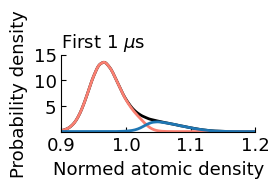

In [14]:
from scipy.stats import gaussian_kde
def plot_3density_distr(data, data_0, data_1, title='First 1 '):
	# 将二维数组转换为一维数组
	data = data.ravel()
	data_0 = data_0.ravel()
	data_1 = data_1.ravel()
	"""
	绘制总体分布以及类别 0 和类别 1 的分布图，并保证类别 0 和类别 1 的概率密度和为总体分布。
	
	Parameters:
	- data: 所有样本的分布
	- data_0: 标签为 0 的样本分布
	- data_1: 标签为 1 的样本分布
	- title: 图的标题
	"""
	# 权重
	weight_0 = len(data_0) / len(data)
	weight_1 = len(data_1) / len(data)

	# 核密度估计：总体分布
	kde_overall = gaussian_kde(data)
	x_vals = np.linspace(min(data) - 0.1, max(data) + 0.1, 500)
	overall_density = kde_overall(x_vals)

	# 正态分布拟合
	mean_0, std_0 = np.mean(data_0), np.std(data_0)
	mean_1, std_1 = np.mean(data_1), np.std(data_1)

	# std_0 = max(std_0, 0.13)  # 确保类别 1 的标准差不太小
	# std_1 = max(std_1, 0.11)  # 确保类别 1 的标准差不太小

	density_0 = norm.pdf(x_vals, loc=mean_0, scale=std_0) * weight_0
	density_1 = norm.pdf(x_vals, loc=mean_1, scale=std_1) * weight_1

	# 确保类别密度加和等于总体密度
	density_sum = density_0 + density_1
	density_0 = density_0 * (overall_density / density_sum)
	density_1 = density_1 * (overall_density / density_sum)

	# if label == 'Lo':
	#     color = '#1f77b4'
	# elif label == 'Ld':
	#     color = '#B22222'
	# else:
	#     color = '#FA8072'
	# 绘图
	fig, ax = plt.subplots(figsize=(2.5, 1))
	# plt.plot(x_vals, overall_density, color='#FA8072', label='All', linewidth=2)
	plt.plot(x_vals, overall_density, color='black', label='All', linewidth=2)
	# plt.plot(x_vals, density_0, color='#B22222', label='Ld', linewidth=2)
	plt.plot(x_vals, density_0, color='#FA8072', label='Ld', linewidth=2)
	plt.plot(x_vals, density_1, color='#1f77b4', label='Lo', linewidth=2)
	# 添加系统名称标注
	# plt.text(0, 1.1, title + 'ns', 
	plt.text(0, 1.1, title + r'$\mu$s', 
			 fontsize=13, ha='left', transform=plt.gca().transAxes)
	# 添加标题和标签
	# plt.title(title, fontsize=14)
	plt.xlabel('Normed atomic density', fontsize=13)
	plt.ylabel('Probability density', fontsize=13)
	plt.xlim(0.9,1.2)
	plt.ylim(0,15)
	# plt.ylim(0, 2.5)
	# plt.yticks(np.arange(0, 6.5, 2))
	plt.yticks(np.arange(5, 16, 5), fontsize = 13)
	# plt.yticks(np.arange(0, 2.5, 1))
	# plt.tick_params(axis='x', which='both', labelbottom=False)
	# plt.yticks([0.2, 0.5, 0.2])
	plt.xticks(np.arange(0.9, 1.21, 0.1), fontsize = 13)
	# plt.legend(fontsize=10)
	plt.tick_params(direction = 'in')
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	# 调整布局并显示图像
	plt.savefig(
	    '/data/gulab/yzdai/data4/phase_identification/plot/output/'+'without_threshold.png',        # 文件名
	    dpi=350,             # 分辨率
	    format='png',        # 文件格式
	    bbox_inches='tight', # 自动调整边界框
	    pad_inches=0.0,      # 边界填充
	    # facecolor='white',   # 背景颜色
	    # edgecolor='black',   # 边缘颜色
	    transparent=True,   # 是否透明背景
	    # metadata={'Author': 'Your Name'}  # 元数据
	)

split_idx = len(flattened_matrix) // 2
h_atom_up_mean_all_normed_filtered = flattened_matrix[:split_idx].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
h_atom_low_mean_all_normed_filtered = flattened_matrix[split_idx:].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])

# 动态阈值
threshold_max_10us = 1.044
threshold_min_10us = 1.021
n_fr  = np.array(h_atom_low_mean_all_normed_filtered).shape[0]
tags_up_all = []; tags_low_all = []
for fr in range(n_fr):
	filter_fr = threshold_max_10us - (threshold_max_10us - threshold_min_10us) * fr/n_fr
	density_up_filtered_fr = h_atom_up_mean_all_normed_filtered[fr]
	tags_up_fr = (density_up_filtered_fr > filter_fr).astype(int)
	tags_up_all.append(tags_up_fr)
	density_low_filtered_fr = h_atom_low_mean_all_normed_filtered[fr]
	tags_low_fr = (density_low_filtered_fr > filter_fr).astype(int)
	tags_low_all.append(tags_low_fr)
tags_up_flattened = np.array(tags_up_all).reshape(n_leaflet_samples, -1).tolist()
tags_low_flattened = np.array(tags_low_all).reshape(n_leaflet_samples, -1).tolist()
tags = tags_up_flattened + tags_low_flattened
tags = np.array(tags)

# # # 用平衡阶段的阈值
# threshold = 1.020
# tags = np.where(flattened_matrix > threshold, 1, 0)


plot_3density_distr(flattened_matrix,
					flattened_matrix[tags == 0], 
					flattened_matrix[tags == 1])

In [17]:
# 将标签数组重新分割为tag_up和tag_low，并还原其形状
split_idx = len(tags) // 2
tag_matrixs_up = tags[:split_idx].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
tag_matrixs_low = tags[split_idx:].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
# 在像素化平面针对grid的tag进行空间平滑
final_tag_matrixs_up = deepcopy(tag_matrixs_up)
final_tag_matrixs_low = deepcopy(tag_matrixs_low)
for n_fr in range(h_up_all.shape[0]):
	tag_matrix_up_fr = tag_matrixs_up[n_fr]
	tag_matrix_low_fr = tag_matrixs_low[n_fr]
	final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrix_up_fr, iter=1) #控制是否平滑
	final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrix_low_fr, iter=1) #控制是否平滑
lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)
# plot_matrix(lips_tag_smoothed, title="Matrix with NaN Values", cmap='viridis')
print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')

end of phase identification
shape of lips_tag:	 (200, 1152)
---------------------------------



# 高斯估计

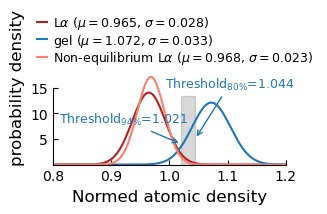

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# 分布参数
params = {
	"L$\\alpha$": {
		"mean": 0.9645677557647706,
		"std": 0.028453923465669103
	},
	"gel": {
		"mean": 1.072051964170829,
		"std": 0.033037772879500604
	},
	"Non-equilibrium L$\\alpha$": {
		"mean": 0.9681686143790851,
		"std": 0.023363581009091403
	}
}

# 设置绘图范围
x = np.linspace(0.5, 1.4, 500)  # 从 0.6 到 1.4 生成 500 个点
# 计算 Lo 分布的左侧显著下界
z_score_95 = norm.ppf(0.99)  # 对应单侧 95% 显著水平的 Z 值
# z_score_95 = 1.645  # 对应单侧 95% 显著水平的 Z 值
mu_lo = params["Non-equilibrium L$\\alpha$"]["mean"]
sigma_lo = params["Non-equilibrium L$\\alpha$"]["std"]
left_bound = mu_lo + z_score_95 * sigma_lo

# 计算 Lo 分布的左侧显著下界
z_score = norm.ppf(0.99)  # 对应单侧 95% 显著水平的 Z 值
# z_score_95 = 1.645  # 对应单侧 95% 显著水平的 Z 值
mu_lo = params["L$\\alpha$"]["mean"]
sigma_lo = params["L$\\alpha$"]["std"]
left_bound_Ld = mu_lo + z_score_95 * sigma_lo

# Step 2: 计算 85% 单侧显著性的下界
z_score_80 = norm.ppf(0.80)  # 单侧 % 的 Z 值
z_score_90 = norm.ppf(0.94)  # 单侧 % 的 Z 值
mu_lo = params["gel"]["mean"]
sigma_lo = params["gel"]["std"]
lower_bound_80 = mu_lo - z_score_80 * sigma_lo
lower_bound_90 = mu_lo - z_score_90 * sigma_lo

# 绘制分布
plt.figure(figsize=(3, 2))
for label, param in params.items():
	mean = param["mean"]
	std = param["std"]
	y = norm.pdf(x, loc=mean, scale=std)  # 计算正态分布的概率密度
	if label == 'gel':
		color = '#1f77b4'
	elif label == 'L$\\alpha$':
		color = '#B22222'
	else:
		color = '#FA8072'
	plt.plot(x, y,color=color, label=rf"{label} ($\mu={mean:.3f}$, $\sigma={std:.3f}$)")  # 绘制曲线
	
# 在 Lo 分布上添加左侧显著性的红线
# plt.axvline(left_bound, color='red', linestyle='--', label=f"ubLd 99% Right Bound = {left_bound:.3f}")
# plt.axvline(left_bound_Ld, color='black', linestyle='--', label=f"Ld 99% Right Bound = {left_bound_Ld:.3f}")
# plt.axvline(lower_bound_80, color='gray', linestyle='--', label=f"Lo 80% Left Bound = {lower_bound_80:.3f}")
# plt.axvline(lower_bound_90, color='black', linestyle='--', label=f"Lo 96% Left Bound = {lower_bound_90:.3f}")
# plt.axvline(1.065, color='blue', linestyle='--', label=f"Lo vs ubLd = 1.065")
# plt.axvline(1.04, color='green', linestyle='--', label=f"Lo vs Ld = 1.04")

# 阈值范围填充
plt.axvspan(lower_bound_90, lower_bound_80, ymax=8/18,color='gray', alpha=0.3, label='_nolegend_')  # 填充矩形区域，不加入图例
# 修改左侧标注
plt.annotate(
	rf"Threshold$_{{94\%}}$={lower_bound_90:.3f}",  # 格式化文本
	xy=(lower_bound_90, 4),  # 箭头指向位置
	xytext=(lower_bound_90-0.1, 8),  # 文本位置
	# arrowprops=dict(facecolor='black', arrowstyle='->'), 
	arrowprops=dict(facecolor='#1f77b4', edgecolor='#1f77b4', arrowstyle='->'),  # 修改箭头颜色为蓝色
	fontsize=9, color='#1f77b4', ha='center'
)

# 修改右侧标注
plt.annotate(
	rf"Threshold$_{{80\%}}$={lower_bound_80:.3f}",  # 格式化文本
	xy=(lower_bound_80, 5),  # 箭头指向位置
	xytext=(lower_bound_80 + 0.06, 15),  # 文本位置
	# arrowprops=dict(facecolor='gray', arrowstyle='->'), 
	arrowprops=dict(facecolor='#1f77b4', edgecolor='#1f77b4', arrowstyle='->'),  # 修改箭头颜色为蓝色
	fontsize=9, color='#1f77b4', ha='center'
)

# 添加图例和标题
# plt.title("Probability Density Functions with Lo Left Significance", fontsize=14)
plt.xlim(0.8,1.2)
plt.ylim(0,30)
# plt.yticks(np.arange(2,25,4))
plt.xlabel("Normed atomic density", fontsize=12)
plt.ylabel("probability density", fontsize=12)
# plt.legend(fontsize=8,loc='best')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=1, fontsize=8)
# 添加图例，放置在图形下方
plt.legend(
	fontsize=9, 
	loc='upper left', 
	bbox_to_anchor=(-0.12,1.05),  # 控制图例在图形下方的位置
	# ncol=1, 
	frameon=False,
	labelspacing=0.05,      # 控制图例项之间的垂直间距
	handlelength=0.8,      # 控制图例标记的长度
	handletextpad=0.5      # 控制图例标记和文字之间的水平间距
)
plt.tick_params(direction='in')
# 隐藏顶部和右侧坐标轴线
plt.yticks([5, 10, 15])  # 仅显示 y 轴刻度 2, 6, 10
ax = plt.gca()
ax.spines['left'].set_bounds(0, 15)  # 限制 y 轴显示范围为 2 到 10
ax.spines['top'].set_visible(False)  # 隐藏顶部边框
ax.spines['right'].set_visible(False)  # 隐藏右侧边框

# 显示图像
plt.savefig(
	'/data/gulab/yzdai/data4/phase_identification/plot/output/threshold.png',        # 文件名
	dpi=350,             # 分辨率
	format='png',        # 文件格式
	bbox_inches='tight', # 自动调整边界框
	pad_inches=0.0,      # 边界填充
	# facecolor='white',   # 背景颜色
	# edgecolor='black',   # 边缘颜色
	transparent=True,   # 是否透明背景
	# metadata={'Author': 'Your Name'}  # 元数据
)


In [44]:
import numpy as np

# 查找大于 1 或小于 0 的元素
condition = (np.array(h_atom_up_mean_all) > 1) | (np.array(h_atom_up_mean_all) <= 0)  # 满足条件的布尔数组

# 获取符合条件的元素的索引
indices = np.where(condition)

# 如果存在符合条件的元素，则输出其索引
if indices[0].size > 0:
	print("发现大于1或小于0的元素，索引为：")
	for idx in zip(*indices):
		print(idx, np.array(h_atom_up_mean_all)[idx])  # 输出索引和对应的元素值
else:
	print("没有发现大于1或小于0的元素")


发现大于1或小于0的元素，索引为：
(49, 54, 38) 0.0
(72, 54, 39) 0.0
(106, 53, 42) 0.0
(107, 53, 43) 0.0
(127, 51, 45) 0.0
(127, 51, 46) 0.0
(150, 58, 48) 0.0
(197, 54, 42) 0.0


start: 9000 	end: 10000 
density_mean: 0.3452694396184943


/data/gulab/yzdai/anaconda3/envs/density/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/data/gulab/yzdai/anaconda3/envs/density/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  


start of plotting
Lo min:	 1.020178
Ld max:	 1.020177
end of clustering all


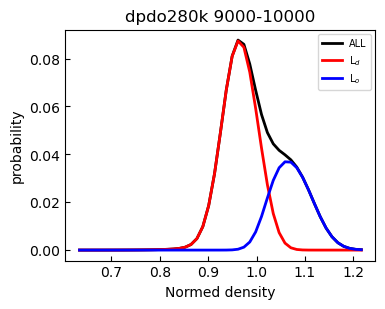

In [5]:
if gmm_param != 'None':
	with open(gmm_param, 'r') as json_file:
		params = json.load(json_file)
	density_mean = params['density']['mean']
else:
	density_mean = np.mean(h_atom_up_mean_all)/2+np.mean(h_atom_low_mean_all)/2

print('start:',start,'\tend:',end,'\ndensity_mean:',density_mean)
h_atom_up_mean_all_normed = [matrix / density_mean for matrix in h_atom_up_mean_all]
h_atom_low_mean_all_normed = [matrix / density_mean for matrix in h_atom_low_mean_all]
h_atom_up_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_up_mean_all_normed]
h_atom_low_mean_all_normed_filtered = [spatial_smooth(matrix) for matrix in h_atom_low_mean_all_normed] 

if(cal_ratio):
	h_ratio_up_all = [h_primary_lipid_up_sum_all[fr]/h_atom_up_sum_all[fr] for fr in range(len(h_primary_lipid_up_sum_all))]
	h_ratio_low_all = [h_primary_lipid_low_sum_all[fr]/h_atom_low_sum_all[fr] for fr in range(len(h_primary_lipid_low_sum_all))]
	h_ratio_up_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_up_all]
	h_ratio_low_all_filtered = [spatial_smooth(matrix) for matrix in h_ratio_low_all]

def cluster_using_density(h_up_all, h_low_all, k=2, iter=1, gmm_param='None'):
	h_up_all = np.array(h_up_all)
	h_low_all = np.array(h_low_all)
	# 将数组转换为2D形式，以便进行KMeans聚类
	n_leaflet_samples = h_up_all.shape[0]*h_up_all.shape[1]*h_up_all.shape[2]
	density_up_flattened = h_up_all.reshape(n_leaflet_samples, -1).tolist()
	density_low_flattened = h_low_all.reshape(n_leaflet_samples, -1).tolist()
	density_flattened = density_up_flattened + density_low_flattened
	# [atom]
	flattened_matrix = np.array(deepcopy(density_flattened)).reshape(-1,1)
	plot_density_distr(flattened_matrix, title=sys+' '+str(start)+'-'+str(end))
	if (gmm_param == 'None'):
		# Step 1: 高斯混合模型拟合
		gmm = GaussianMixture(n_components=k, random_state=0).fit(flattened_matrix)   
		raw_tags = gmm.predict(flattened_matrix)

		# Step 2: 对 raw_tags 进行处理，得到最终标签 tags
		tags = get_tag_by_first_feature(flattened_matrix,raw_tags)

		# Step 3: 根据 tags 提取 Lo 和 Ld 的分布参数
		ld_indices = (tags == 0)  # Ld 标签为 0
		lo_indices = (tags == 1)  # Lo 标签为 1
		# 提取 Ld 和 Lo 样本
		ld_samples = flattened_matrix[ld_indices]
		lo_samples = flattened_matrix[lo_indices]
		# 计算 Ld 和 Lo 的均值和标准差
		mu_ld, sigma_ld = ld_samples.mean(), ld_samples.std()
		mu_lo, sigma_lo = lo_samples.mean(), lo_samples.std()
		min_lo = min(flattened_matrix[tags == 1])
		max_ld = max(flattened_matrix[tags == 0])
		# Step 4: 保存到 JSON 文件
		output_data = {
			"Ld": {
				"tag": 0,
				"mean": float(mu_ld),
				"std": float(sigma_ld),
				"max density": float(max_ld)
			},
			"Lo": {
				"tag": 1,
				"mean": float(mu_lo),
				"std": float(sigma_lo),
				"min density": float(min_lo)
			},
			"density": {
				"mean": float(density_mean)
			}
		}
		with open(os.path.join(os.path.dirname(os.path.abspath(outpath)), 'gmm_parameters.json'), 'w') as json_file:
			json.dump(output_data, json_file, indent=4)
	else:
		# Step 1: 高斯混合模型拟合
		gmm = GaussianMixture(n_components=k, random_state=0).fit(flattened_matrix)   
		raw_tags = gmm.predict(flattened_matrix)

		# Step 2: 对 raw_tags 进行处理，得到最终标签 tags
		tags = get_tag_by_first_feature(flattened_matrix,raw_tags)
   
	print('Lo min:\t',flattened_matrix[tags == 1].min())
	print('Ld max:\t',flattened_matrix[tags == 0].max())
	plot_3density_distr(flattened_matrix,
					flattened_matrix[tags == 0], 
					flattened_matrix[tags == 1], 
					title=sys+' '+str(start)+'-'+str(end))
	
	# 将标签数组重新分割为tag_up和tag_low，并还原其形状
	split_idx = len(tags) // 2
	tag_matrixs_up = tags[:split_idx].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
	tag_matrixs_low = tags[split_idx:].reshape(h_up_all.shape[0],h_up_all.shape[1],h_up_all.shape[2])
	# 在像素化平面针对grid的tag进行空间平滑
	final_tag_matrixs_up = deepcopy(tag_matrixs_up)
	final_tag_matrixs_low = deepcopy(tag_matrixs_low)
	for n_fr in range(h_up_all.shape[0]):
		tag_matrix_up_fr = tag_matrixs_up[n_fr]
		tag_matrix_low_fr = tag_matrixs_low[n_fr]
		final_tag_matrixs_up[n_fr] = remove_isolated_points_and_smooth(tag_matrix_up_fr, iter=iter) #控制是否平滑
		final_tag_matrixs_low[n_fr] = remove_isolated_points_and_smooth(tag_matrix_low_fr, iter=iter) #控制是否平滑
	print('end of clustering all')
	return final_tag_matrixs_up, final_tag_matrixs_low
# 获得所有帧 所有格子的tag
tag_matrixs_up, tag_matrixs_low = cluster_using_density(h_atom_up_mean_all_normed_filtered, h_atom_low_mean_all_normed_filtered, 
											  k=2, iter=1, gmm_param=gmm_param)

(200, 60, 60)


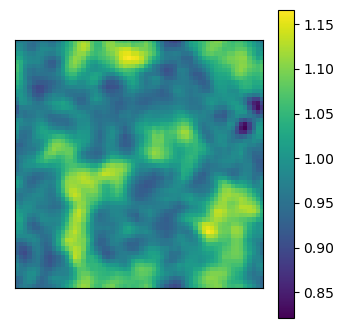

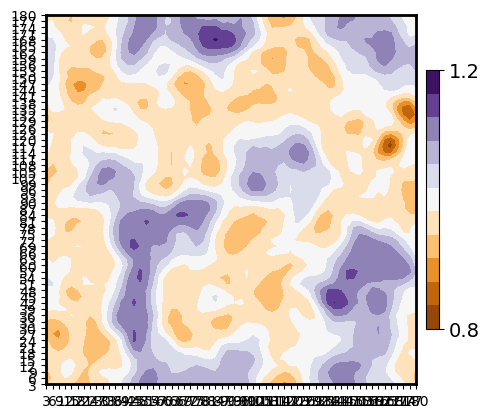

In [6]:
h = h_atom_up_mean_all_normed_filtered[45]
print(np.array(h_atom_low_mean_all_normed_filtered).shape)
def plot_matrix(matrix, title="Matrix Plot", cmap='viridis'):
	"""
	使用指定的颜色映射绘制给定的n*m矩阵。
	
	参数:
	- matrix: 要绘制的二维numpy数组 (n, m)
	- title: 图像的标题，默认为 "Matrix Plot"
	- cmap: 使用的颜色映射，默认为 'viridis'
	"""
	rotated_matrix = np.flipud(np.transpose(matrix))
	plt.figure(figsize=(4, 4))
	# 使用imshow绘制矩阵，并应用颜色映射
	plt.imshow(rotated_matrix, cmap=cmap, origin='lower')
	plt.gca().invert_yaxis()  # 反转Y轴
	plt.colorbar()  # 添加颜色条以显示值的范围
	# 隐藏x轴和y轴的刻度
	plt.xticks([])
	plt.yticks([])
	plt.show()
plot_matrix(h, title="Matrix with NaN Values", cmap='viridis')
def plotDensmap(data, edge):
	normData = np.copy(data)
	normData = np.where (normData <1.2, normData, 1.2)
	normData = np.where (normData >0.8, normData, 0.8)
	normData = np.where (np.isnan(data), np.nan, normData)

	# levels = LinearLocator(numticks=7).tick_values(0.8, 1.5)
	levels = LinearLocator(numticks=12).tick_values(0.8, 1.2)
	cmap = plt.get_cmap('PuOr')
	xMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	yMatrix = np.zeros((normData.shape[0], normData.shape[1]))
	
	xaxis = edge[0][1:]
	yaxis = edge[1][1:]
	for i in range(0, normData.shape[0]):
		xMatrix[i, :] = xaxis
	for j in range(0, normData.shape[1]):
		yMatrix[:, j] = yaxis
	im = plt.contourf(yMatrix,
			 xMatrix, normData, levels=levels,
			 cmap=cmap)
	# im = plt.pcolormesh(yMatrix, xMatrix, normData, cmap=cmap)#, shading='auto', edgecolors='w', linewidth=0.5
	densmap = plt.gca()
	densmap.set_aspect(1)
	#set border width
	densmap.spines['bottom'].set_linewidth(2)
	densmap.spines['left'].set_linewidth(2)
	densmap.spines['top'].set_linewidth(2)
	densmap.spines['right'].set_linewidth(2)
	# densmap.tick_params(axis='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
	
	densmap.tick_params(
			axis='both',          # 应用于两个轴
			which='both',         # 同时影响主刻度和次刻度
			bottom=True,          # 显示底部刻度
			top=False,            # 不显示顶部刻度
			left=True,            # 显示左侧刻度
			right=False,          # 不显示右侧刻度
			labelbottom=True,     # 显示底部刻度标签
			labelleft=True        # 显示左侧刻度标签
		)

	# 设置 X 轴和 Y 轴的刻度
	x_ticks = [round(x, 2) for x in xaxis]  # X 轴的刻度值
	y_ticks = [round(y, 2) for y in yaxis]  # Y 轴的刻度值
	densmap.set_xticks(x_ticks)  # 设置 X 轴刻度
	densmap.set_yticks(y_ticks)  # 设置 Y 轴刻度

	# 添加 colorbar
	cbar = plt.colorbar(im, ax=densmap, orientation='vertical', pad=0.02, shrink=0.7)
	# 平滑 colorbar，并只标注首尾的值
	cbar.set_ticks([0.8, 1.2])  # 设置 colorbar 的刻度为首尾
	cbar.set_ticklabels(['0.8', '1.2'])  # 定义刻度标签
	cbar.ax.tick_params(labelsize=14)  # 调整刻度字体大小
	return im
im = plotDensmap(h, edge3d) 

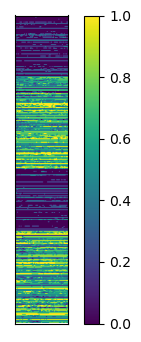

end of phase identification
shape of lips_tag:	 (200, 1152)
---------------------------------



In [8]:
lips_tag = get_lipis_tags(tag_matrixs_up, tag_matrixs_low, lips_grid_ndx)
lips_tag = np.array(lips_tag)
lips_tag_smoothed = temporal_smoothing(lips_tag)
lips_tag_smoothed = np.array(lips_tag_smoothed)
plot_matrix(lips_tag_smoothed, title="Matrix with NaN Values", cmap='viridis')
print('end of phase identification')
print('shape of lips_tag:\t',lips_tag.shape)
print('---------------------------------\n')
outfn_raw = outpath+sys+'-rawdata.xvg'
outfn_upper_phase1 = outpath+sys+'-upper-phase1.xvg'
outfn_upper_phase2 = outpath+sys+'-upper-phase2.xvg'
outfn_lower_phase1 = outpath+sys+'-lower-phase1.xvg'
outfn_lower_phase2 = outpath+sys+'-lower-phase2.xvg'
outf_raw = open(outfn_raw, 'w')
outf_upper_phase1 = open(outfn_upper_phase1, 'w')
outf_upper_phase2 = open(outfn_upper_phase2, 'w')
outf_lower_phase1 = open(outfn_lower_phase1, 'w')
outf_lower_phase2 = open(outfn_lower_phase2, 'w')

lip_leaflet = []
for i in range(start,end,n_gap):
	fn_leaflets = lip_leaflet_raw[i:i+n_gap, :]
	most_common_leaflet_tag = [Counter(column).most_common(1)[0][0] for column in zip(*fn_leaflets)]
	lip_leaflet.append(most_common_leaflet_tag)
lip_leaflet = np.array(lip_leaflet)

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_raw,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		print('%d' % (lips_tag_smoothed[i][j]),file= outf_raw,end=' ')
	print('\n',file= outf_raw,end='')

for i in range(0, len(lips_tag_smoothed)):
	print('%d' % (start + 5*i),file=outf_upper_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_upper_phase2,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase1,end=' ')
	print('%d' % (start + 5*i),file=outf_lower_phase2,end=' ')
	for j in range(0, len(lips_tag_smoothed[0])):
		if lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase1,end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 0):
			print('%d' % (j+1),file=outf_upper_phase2,end=' ')
		elif lips_tag_smoothed[i][j] == 0 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1), file=outf_lower_phase1, end=' ')
		elif lips_tag_smoothed[i][j] == 1 and (lip_leaflet[i, j] == 1):
			print('%d' % (j+1),file=outf_lower_phase2,end=' ')
	print( '\n',file=outf_upper_phase1,end='')
	print( '\n',file=outf_upper_phase2,end='')
	print( '\n',file=outf_lower_phase1,end='')
	print( '\n',file=outf_lower_phase2,end='')